0.9532938882890918
0.6996245918368057
0.6996245918368066


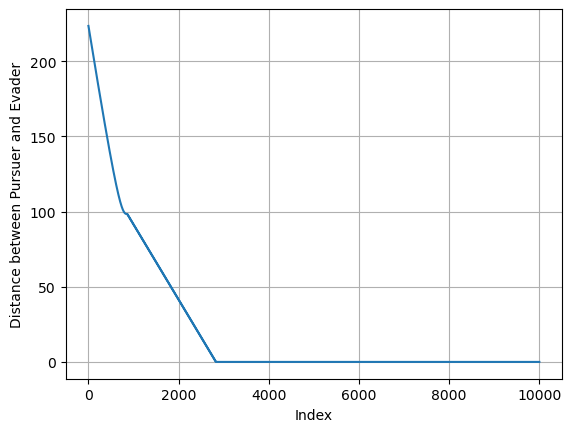

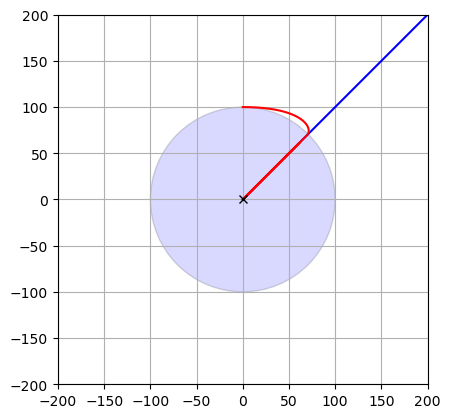

In [153]:
# Example Phython Code for Perimeter Defense
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl

# Pursuer-Evader Initial Position
t_end = 1000
n = 10001
X_pursuer = np.array([[0], [100]])
X_evader = np.array([[200], [200]])
t = np.linspace(0,t_end, n)
V_pursuer = 1
V_evader = 1

X_pursuer_past = X_pursuer
X_evader_past = X_evader
d_vec = np.zeros(shape=(2, n-1))
for i in range(1, n):
    # Path for Evader
    dt = t[i]-t[i-1]
    direc_ang_evader = X_evader_past-np.array([[0], [0]])
    direc_ang_evader = np.arctan2(-direc_ang_evader[1], -direc_ang_evader[0])+np.pi*2
    direc_unitvec_evader = np.array([np.cos(direc_ang_evader), np.sin(direc_ang_evader)])
    X_evader_curr = X_evader_past + V_evader*direc_unitvec_evader*dt
    X_evader = np.column_stack((X_evader, X_evader_curr))
    X_evader_past = X_evader_curr
    
    # Path for Pursuer
    dt = t[i]-t[i-1]
    midpoint = (X_evader_past-np.array([[0], [0]]))/2
    direc_ang_pursuer = X_pursuer_past-midpoint
    direc_ang_pursuer = np.arctan2(-direc_ang_pursuer[1], -direc_ang_pursuer[0])+np.pi*2
    direc_unitvec_pursuer = np.array([np.cos(direc_ang_pursuer), np.sin(direc_ang_pursuer)])
    X_pursuer_curr = X_pursuer_past + V_pursuer*direc_unitvec_pursuer*dt
    X_pursuer = np.column_stack((X_pursuer, X_pursuer_curr))
    X_pursuer_past = X_pursuer_curr
    
    # Interception Check
    delta = X_pursuer_curr - X_evader_curr
    d = np.linalg.norm(delta)
    d_vec[0, i-1] = i
    d_vec[1, i-1] = d

tol = 1
for i in range(0, n-1):
    if d_vec[1,i] <= tol:
        dmin_first = i
        print(d_vec[1, i])
        break

# Check first intercept
fig1 = plt.figure(1)
plt.plot(d_vec[0], d_vec[1])
plt.grid(True)
plt.xlabel('Index')
plt.ylabel('Distance between Pursuer and Evader')

# Visualization
# Build Perimeter Zone
fig2 = plt.figure(2)
# Setup Perimeter
perimeter = plt.Circle((0, 0), 100, fc='blue', ec='black', alpha=0.15)
plt.gca().add_patch(perimeter)
plt.plot(np.transpose(X_evader[0]), np.transpose(X_evader[1]), '-b')
plt.plot(np.transpose(X_pursuer[0]), np.transpose(X_pursuer[1]), '-r')
print(X_pursuer[0, dmin_first])
print(X_pursuer[1, dmin_first])
plt.plot(X_pursuer[0, dmin_first], X_pursuer[1, dmin_first], 'xk')
plt.axis('scaled')
plt.xlim(-200, 200)
plt.ylim(-200, 200)
plt.grid(True)
plt.show()